# Q. Perform Sentimental Analysis on the Elon-musk tweets

## Importing Libraries

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import time
import string
import warnings

# for all NLP related operations on text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# To identify the sentiment of text
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor

# For Deploy
import pickle
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.pipeline import make_pipeline
from nltk.tokenize import RegexpTokenizer

# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
stopwords = set(stopwords.words("english"))

# for showing all the plots inline
%matplotlib inline

[nltk_data] Downloading package stopwords to C:\Users\Rohit
[nltk_data]     Shelar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Rohit
[nltk_data]     Shelar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Rohit
[nltk_data]     Shelar\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Rohit Shelar\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to C:\Users\Rohit
[nltk_data]     Shelar\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Rohit
[nltk_data]     Shelar\AppData\Roaming\nltk_

## Importing Dataset - Tweets

In [3]:
tweets=pd.read_csv('Elon_musk.csv',encoding='Latin-1')
tweets.drop(['Unnamed: 0'],inplace=True,axis=1)
tweets.rename({'Text':'Tweets'},axis=1,inplace=True)
tweets

,Tweets
0,@kunalb11 Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...
...,...
1994,"@flcnhvy True, it sounds so surreal, but the n..."
1995,@PPathole Make sure to read ur terms &amp; con...
1996,@TeslaGong @PPathole Samwise Gamgee
1997,@PPathole Altho Dumb and Dumber is <U+0001F525...


In [4]:
# 1 way
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

In [5]:
# 2 way
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

In [12]:
sentiments_using_SIA = tweets.Tweets.apply(lambda tweet: fetch_sentiment_using_SIA(tweet))
pd.DataFrame(sentiments_using_SIA.value_counts())

,Tweets
pos,1769
neg,230


In [14]:
sentiments_using_textblob = tweets.Tweets.apply(lambda tweet: fetch_sentiment_using_textblob(tweet))
pd.DataFrame(sentiments_using_textblob.value_counts())

,Tweets
pos,1783
neg,216


### Observation:
**NLTK gives us more negative sentiments than TexBlob, so we will prefer NLTK, since classfication seems better.**

In [15]:
tweets['sentiment'] = sentiments_using_SIA
tweets.head()

,Tweets,sentiment
0,@kunalb11 Im an alien,pos
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,pos
2,@joerogan @Spotify Great interview!,pos
3,@gtera27 Doge is underestimated,neg
4,@teslacn Congratulations Tesla China for amazi...,pos


# Text Pre-processing

## A. Pre-processing 'Key Words'
### a. Removing '@names'
Here we can see that at many places we have '@names', which are of no use, since it don't have any meaning, So they need to be removed.

In [16]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text 

In [21]:
#We are keeping cleaned tweets in a new column called 'tidy_tweets'
tweets['tidy_tweets'] = np.vectorize(remove_pattern)(tweets['Tweets'], "@[\w]*: | *RT*")
tweets.head(10)

,Tweets,sentiment,tidy_tweets
0,@kunalb11 Im an alien,pos,@kunalb11 Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,pos,@ID_AA_Carmackay tracing on Cyberpunk with HD ...
2,@joerogan @Spotify Great interview!,pos,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated,neg,@gtera27 Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,pos,@teslacn Congratulations Tesla China for amazi...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,pos,Happy New Year of the Ox! https://t.co/9WFKMYu2oj
6,"Frodo was the underdoge,\nAll thought he would...",neg,"Frodo was the underdoge,\nAll thought he would..."
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),pos,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :)
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,pos,@flcnhvy @anonyx10 Indeed! Tweets definitely d...
9,The most entertaining outcome is the most likely,pos,The most entertaining outcome is the most likely


**Now we don't have '@name' values.**

### b. Removing links (http / https)

In [23]:
cleaned_tweets = []

for index, row in tweets.iterrows():
    
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.tidy_tweets.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

tweets['tidy_tweets'] = cleaned_tweets
tweets.head(10)

,Tweets,sentiment,tidy_tweets
0,@kunalb11 Im an alien,pos,@kunalb11 Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,pos,@ID_AA_Carmackay tracing on Cyberpunk with HD ...
2,@joerogan @Spotify Great interview!,pos,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated,neg,@gtera27 Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,pos,@teslacn Congratulations Tesla China for amazi...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,pos,Happy New Year of the Ox!
6,"Frodo was the underdoge,\nAll thought he would...",neg,"Frodo was the underdoge, All thought he would ..."
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),pos,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :)
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,pos,@flcnhvy @anonyx10 Indeed! Tweets definitely d...
9,The most entertaining outcome is the most likely,pos,The most entertaining outcome is the most likely


### c. Removing tweets with empty text

In [24]:
tweets = tweets[tweets['tidy_tweets']!='']
tweets.head()

,Tweets,sentiment,tidy_tweets
0,@kunalb11 Im an alien,pos,@kunalb11 Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,pos,@ID_AA_Carmackay tracing on Cyberpunk with HD ...
2,@joerogan @Spotify Great interview!,pos,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated,neg,@gtera27 Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,pos,@teslacn Congratulations Tesla China for amazi...


### d. Dropping duplicate rows

In [25]:
tweets.drop_duplicates(subset=['tidy_tweets'], keep=False)
tweets.head()

,Tweets,sentiment,tidy_tweets
0,@kunalb11 Im an alien,pos,@kunalb11 Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,pos,@ID_AA_Carmackay tracing on Cyberpunk with HD ...
2,@joerogan @Spotify Great interview!,pos,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated,neg,@gtera27 Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,pos,@teslacn Congratulations Tesla China for amazi...


### e. Resetting index
It seems that our index needs to be reset, since after removal of some rows, some index values are missing, which may cause problem in future operations.

In [27]:
tweets = tweets.reset_index(drop=True)
tweets.head()

,Tweets,sentiment,tidy_tweets
0,@kunalb11 Im an alien,pos,@kunalb11 Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,pos,@ID_AA_Carmackay tracing on Cyberpunk with HD ...
2,@joerogan @Spotify Great interview!,pos,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated,neg,@gtera27 Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,pos,@teslacn Congratulations Tesla China for amazi...


### f. Removing Punctuations, Numbers and Special characters
This step should not be followed if we also want to do sentiment analysis on key phrases as well, because semantic meaning in a sentence needs to be present. So here we will create one additional column 'absolute_tidy_tweets' which will contain absolute tidy words which can be further used for sentiment analysis on key words.

In [28]:
tweets['absolute_tidy_tweets'] = tweets['tidy_tweets'].str.replace("[^a-zA-Z# ]", "")

C:\Users\Rohit Shelar\AppData\Local\Temp\ipykernel_32372\2315354856.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets['absolute_tidy_tweets'] = tweets['tidy_tweets'].str.replace("[^a-zA-Z# ]", "")


### g. Removing Stop words
With the same reason we mentioned above, we won't perform this on 'tidy_tweets' column, because it needs to be used for key_phrases sentiment analysis.

In [30]:
stopwords_set = set(stopwords)
cleaned_tweets = []

for index, row in tweets.iterrows():
    
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.absolute_tidy_tweets.split() if not word in stopwords_set and '#' not in word.lower()]
    
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    cleaned_tweets.append(' '.join(words_without_stopwords))
    
tweets['absolute_tidy_tweets'] = cleaned_tweets
tweets.head(10)

,Tweets,sentiment,tidy_tweets,absolute_tidy_tweets
0,@kunalb11 Im an alien,pos,@kunalb11 Im an alien,kunalb Im alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,pos,@ID_AA_Carmackay tracing on Cyberpunk with HD ...,IDAACarmackay tracing Cyberpunk HD nextlevel H...
2,@joerogan @Spotify Great interview!,pos,@joerogan @Spotify Great interview!,joerogan Spotify Great interview
3,@gtera27 Doge is underestimated,neg,@gtera27 Doge is underestimated,gtera Doge underestimated
4,@teslacn Congratulations Tesla China for amazi...,pos,@teslacn Congratulations Tesla China for amazi...,teslacn Congratulations Tesla China amazing ex...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,pos,Happy New Year of the Ox!,Happy New Year Ox
6,"Frodo was the underdoge,\nAll thought he would...",neg,"Frodo was the underdoge, All thought he would ...",Frodo underdoge All thought would fail Himself
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),pos,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),OwenSparks flcnhvy anonyx Haha thanks
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,pos,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,flcnhvy anonyx Indeed Tweets definitely repres...
9,The most entertaining outcome is the most likely,pos,The most entertaining outcome is the most likely,The entertaining outcome likely


### h. Tokenize *'absolute_tidy_tweets'*

In [31]:
tokenized_tweet = tweets['absolute_tidy_tweets'].apply(lambda x: x.split())
tokenized_tweet.head()

0                                  [kunalb, Im, alien]
1    [IDAACarmackay, tracing, Cyberpunk, HD, nextle...
2                [joerogan, Spotify, Great, interview]
3                        [gtera, Doge, underestimated]
4    [teslacn, Congratulations, Tesla, China, amazi...
Name: absolute_tidy_tweets, dtype: object

### i. Converting words to Lemma

In [32]:
word_lemmatizer = WordNetLemmatizer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
tokenized_tweet.head()

0                                  [kunalb, Im, alien]
1    [IDAACarmackay, tracing, Cyberpunk, HD, nextle...
2                [joerogan, Spotify, Great, interview]
3                        [gtera, Doge, underestimated]
4    [teslacn, Congratulations, Tesla, China, amazi...
Name: absolute_tidy_tweets, dtype: object

### j. Joining all tokens into sentences

In [33]:
for i, tokens in enumerate(tokenized_tweet):
    tokenized_tweet[i] = ' '.join(tokens)

tweets['absolute_tidy_tweets'] = tokenized_tweet
tweets.head(10)

,Tweets,sentiment,tidy_tweets,absolute_tidy_tweets
0,@kunalb11 Im an alien,pos,@kunalb11 Im an alien,kunalb Im alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,pos,@ID_AA_Carmackay tracing on Cyberpunk with HD ...,IDAACarmackay tracing Cyberpunk HD nextlevel H...
2,@joerogan @Spotify Great interview!,pos,@joerogan @Spotify Great interview!,joerogan Spotify Great interview
3,@gtera27 Doge is underestimated,neg,@gtera27 Doge is underestimated,gtera Doge underestimated
4,@teslacn Congratulations Tesla China for amazi...,pos,@teslacn Congratulations Tesla China for amazi...,teslacn Congratulations Tesla China amazing ex...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,pos,Happy New Year of the Ox!,Happy New Year Ox
6,"Frodo was the underdoge,\nAll thought he would...",neg,"Frodo was the underdoge, All thought he would ...",Frodo underdoge All thought would fail Himself
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),pos,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),OwenSparks flcnhvy anonyx Haha thanks
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,pos,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,flcnhvy anonyx Indeed Tweets definitely repres...
9,The most entertaining outcome is the most likely,pos,The most entertaining outcome is the most likely,The entertaining outcome likely


## B. Pre-processing 'Key Phrases'a. Helper class, will help in preprocessing phrase terms
### a. Helper class, will help in preprocessing phrase terms

In [34]:
class PhraseExtractHelper(object):
    def __init__(self):
        self.lemmatizer = nltk.WordNetLemmatizer()
        self.stemmer = nltk.stem.porter.PorterStemmer()
    
    def leaves(self, tree):
        """Finds NP (nounphrase) leaf nodes of a chunk tree."""
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
            yield subtree.leaves()

    def normalise(self, word):
        """Normalises words to lowercase and stems and lemmatizes it."""
        word = word.lower()
        
        # word = self.stemmer.stem_word(word) # We will loose the exact meaning of the word 
        word = self.lemmatizer.lemmatize(word)
        return word

    def acceptable_word(self, word):
        """Checks conditions for acceptable word: length, stopword. We can increase the length if we want to consider large phrase"""
        accepted = bool(3 <= len(word) <= 40
            and word.lower() not in stopwords
            and 'https' not in word.lower()
            and 'http' not in word.lower()
            and '#' not in word.lower()
            )
        return accepted

    def get_terms(self, tree):
        for leaf in self.leaves(tree):
            term = [ self.normalise(w) for w,t in leaf if self.acceptable_word(w) ]
            yield term

### b. Grammatical rule to identify phrases

In [35]:
sentence_re = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""
chunker = nltk.RegexpParser(grammar)

### c. New feature called 'key_phrases', will contain phrases for corresponding tweet

In [36]:
key_phrases = []
phrase_extract_helper = PhraseExtractHelper()

for index, row in tweets.iterrows(): 
    toks = nltk.regexp_tokenize(row.tidy_tweets, sentence_re)
    postoks = nltk.tag.pos_tag(toks)
    tree = chunker.parse(postoks)

    terms = phrase_extract_helper.get_terms(tree)
    tweet_phrases = []

    for term in terms:
        if len(term):
            tweet_phrases.append(' '.join(term))
    
    key_phrases.append(tweet_phrases)
    
key_phrases[:10]

[['kunalb11', 'alien'],
 ['@id_ aa_carmackay', 'cyberpunk'],
 ['joerogan spotify great interview'],
 ['gtera27 doge'],
 ['teslacn congratulation tesla china', 'execution last year'],
 ['happy new year'],
 ['frodo', 'thought'],
 ['owensparks_ flcnhvy', 'haha thanks'],
 ['flcnhvy', 'tweet', 'real-world time allocation'],
 ['entertaining outcome']]

In obtained key phrases, we can see words like 'year', 'talk', 'appl', 'compan' etc. are present which should never be considered as key phrases.<br> 
- **There is one other simple way to extract key phrases, by using TextBlob (ConllExtractor).**

In [37]:
textblob_key_phrases = []
extractor = ConllExtractor()

for index, row in tweets.iterrows():
    # filerting out all the hashtags
    words_without_hash = [word for word in row.tidy_tweets.split() if '#' not in word.lower()]
    
    hash_removed_sentence = ' '.join(words_without_hash)
    
    blob = TextBlob(hash_removed_sentence, np_extractor=extractor)
    textblob_key_phrases.append(list(blob.noun_phrases))

textblob_key_phrases[:10]

[['kunalb11 i\x92m'],
 ['cyberpunk', 'hd'],
 ['spotify great interview'],
 ['gtera27 doge'],
 ['teslacn congratulations tesla china', 'amazing execution last year'],
 ['happy new year', 'ox'],
 ['frodo'],
 [],
 ['tweets', 'real-world time allocation'],
 []]

**These key phrases seems better, let's consider these key phrase only.**

In [38]:
tweets['key_phrases'] = textblob_key_phrases
tweets.head(10)

,Tweets,sentiment,tidy_tweets,absolute_tidy_tweets,key_phrases
0,@kunalb11 Im an alien,pos,@kunalb11 Im an alien,kunalb Im alien,[kunalb11 im]
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,pos,@ID_AA_Carmackay tracing on Cyberpunk with HD ...,IDAACarmackay tracing Cyberpunk HD nextlevel H...,"[cyberpunk, hd]"
2,@joerogan @Spotify Great interview!,pos,@joerogan @Spotify Great interview!,joerogan Spotify Great interview,[spotify great interview]
3,@gtera27 Doge is underestimated,neg,@gtera27 Doge is underestimated,gtera Doge underestimated,[gtera27 doge]
4,@teslacn Congratulations Tesla China for amazi...,pos,@teslacn Congratulations Tesla China for amazi...,teslacn Congratulations Tesla China amazing ex...,"[teslacn congratulations tesla china, amazing ..."
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,pos,Happy New Year of the Ox!,Happy New Year Ox,"[happy new year, ox]"
6,"Frodo was the underdoge,\nAll thought he would...",neg,"Frodo was the underdoge, All thought he would ...",Frodo underdoge All thought would fail Himself,[frodo]
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),pos,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),OwenSparks flcnhvy anonyx Haha thanks,[]
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,pos,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,flcnhvy anonyx Indeed Tweets definitely repres...,"[tweets, real-world time allocation]"
9,The most entertaining outcome is the most likely,pos,The most entertaining outcome is the most likely,The entertaining outcome likely,[]


# 4. Story Generation and Visualization
## A. Most common words in positive tweets
### Answer can be best found using WordCloud

In [39]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

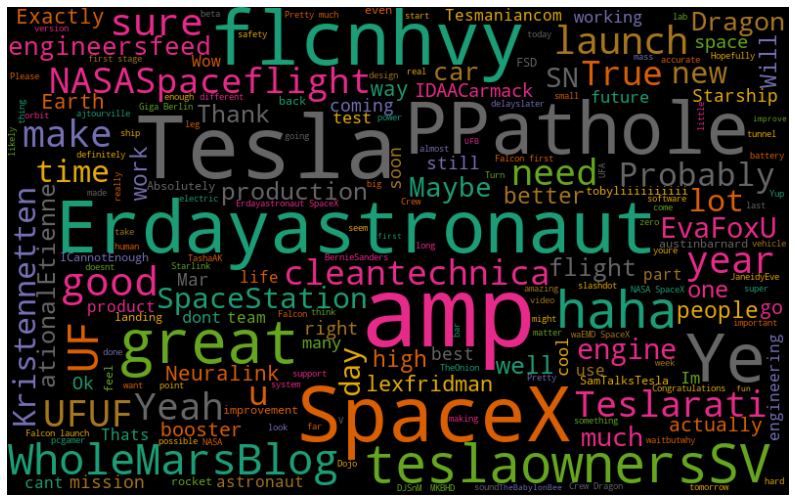

In [41]:
all_words = ' '.join([text for text in tweets['absolute_tidy_tweets'][tweets.sentiment == 'pos']])
generate_wordcloud(all_words)

## B. Most common words in negative tweets

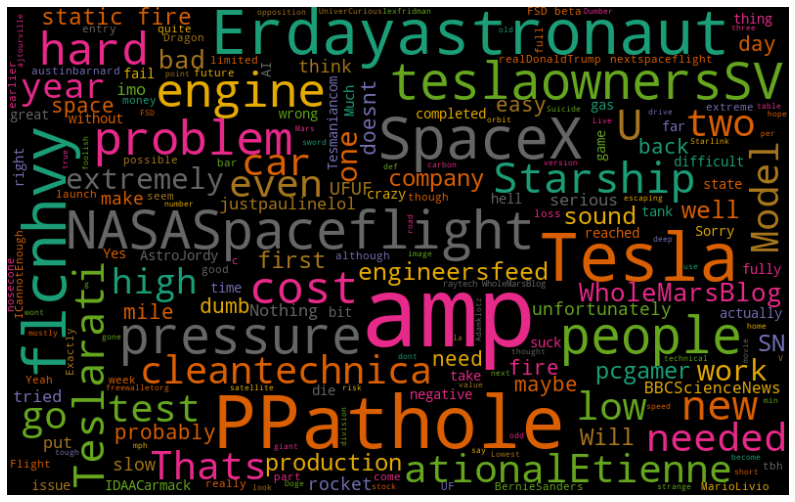

In [42]:
all_words = ' '.join([text for text in tweets['absolute_tidy_tweets'][tweets.sentiment == 'neg']])
generate_wordcloud(all_words)

- AI, DeepLearning and MachineLearning have clearly been used in both positive and negative tweets, which is very obvious. However, in negative tweets we can also see negative words as well like **bad, fail, fire, issue, nothing, low, wrong, negative, problem, slow, serious, hell, etc**.

## C. Most commonly used Hashtags

In [43]:
# function to collect hashtags
def hashtag_extract(text_list):
    hashtags = []
    # Loop over the words in the tweet
    for text in text_list:
        ht = re.findall(r"#(\w+)", text)
        hashtags.append(ht)

    return hashtags

def generate_hashtag_freqdist(hashtags):
    a = nltk.FreqDist(hashtags)
    d = pd.DataFrame({'Hashtag': list(a.keys()),
                      'Count': list(a.values())})
    # selecting top 15 most frequent hashtags     
    d = d.nlargest(columns="Count", n = 25)
    plt.figure(figsize=(16,7))
    ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
    plt.xticks(rotation=80)
    ax.set(ylabel = 'Count')
    plt.show()

In [44]:
hashtags = hashtag_extract(tweets['tidy_tweets'])
hashtags = sum(hashtags, [])

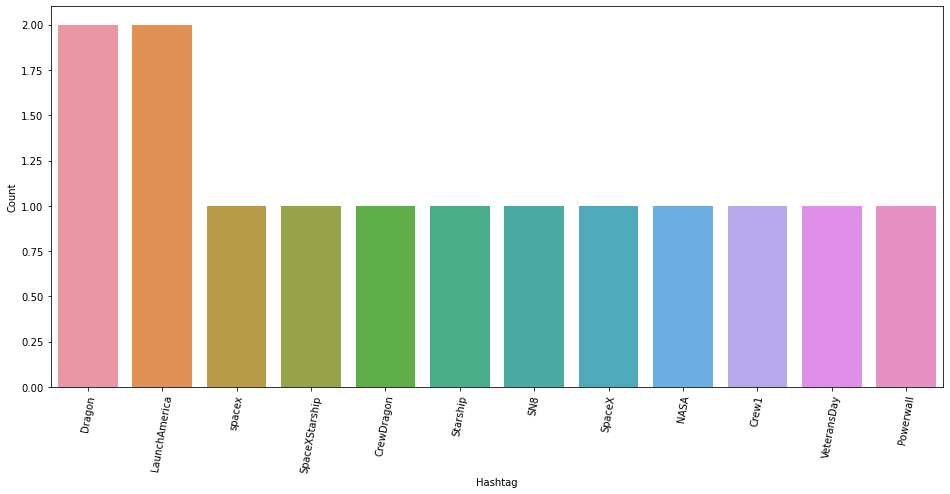

In [45]:
generate_hashtag_freqdist(hashtags)

In [51]:
## For sake of consistency, we are going to discard the records which contains no phrases i.e where tweets_df['key_phrases'] contains []
tweets2 = tweets[tweets['key_phrases'].str.len()>0]

# 5. Feature Extraction
We need to convert textual representation in the form on numeric features. We have two popular techniques to perform feature extraction:

1. Bag of words (Simple vectorization)
2. TF-IDF (Term Frequency - Inverse Document Frequency)
We will use extracted features from both one by one to perform sentiment analysis and will compare the result at last.

### A. Feature Extraction for 'Key Words'

In [52]:
# BOW features
bow_word_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')

# bag-of-words feature matrix
bow_word_feature = bow_word_vectorizer.fit_transform(tweets2['absolute_tidy_tweets'])

# TF-IDF features
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')

# TF-IDF feature matrix
tfidf_word_feature = tfidf_word_vectorizer.fit_transform(tweets2['absolute_tidy_tweets'])

### B. Feature Extraction for 'Key Phrases'

In [53]:
phrase_sents = tweets2['key_phrases'].apply(lambda x: ' '.join(x))

# BOW phrase features
bow_phrase_vectorizer = CountVectorizer(max_df=0.90, min_df=2)
bow_phrase_feature = bow_phrase_vectorizer.fit_transform(phrase_sents)

# TF-IDF phrase feature
tfidf_phrase_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2)
tfidf_phrase_feature = tfidf_phrase_vectorizer.fit_transform(phrase_sents)

# 6. Model Building: Sentiment Analysis

### Mapping target variables to {0, 1}

In [54]:
target_variable = tweets2['sentiment'].apply(lambda x: 0 if x=='neg' else 1)

In [55]:
def plot_confusion_matrix(matrix):
    plt.clf()
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Set2_r)
    classNames = ['Positive', 'Negative']
    plt.title('Confusion Matrix')
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TP','FP'], ['FN', 'TN']]

    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(matrix[i][j]))
    plt.show()

In [56]:
def naive_model(X_train, X_test, y_train, y_test):
    naive_classifier = GaussianNB()
    naive_classifier.fit(X_train.toarray(), y_train)

    # predictions over test set
    predictions = naive_classifier.predict(X_test.toarray())

    # calculating Accuracy Score
    print(f'Accuracy Score - {accuracy_score(y_test, predictions)}')
    conf_matrix = confusion_matrix(y_test, predictions, labels=[True, False])
    plot_confusion_matrix(conf_matrix)

## A. Predictions on 'key words' based features
### a. BOW word features

Accuracy Score - 0.7352941176470589


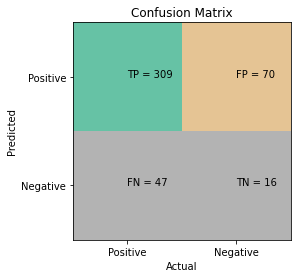

In [57]:
X_train, X_test, y_train, y_test = train_test_split(bow_word_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

### b. TF-IDF word features

Accuracy Score - 0.7352941176470589


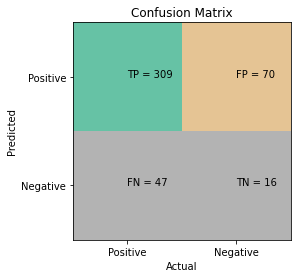

In [58]:
X_train, X_test, y_train, y_test = train_test_split(bow_word_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

## B. Predictions on 'key phrases' based features
### a. BOW Phrase features

Accuracy Score - 0.6063348416289592


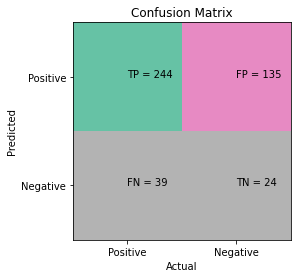

In [59]:
X_train, X_test, y_train, y_test = train_test_split(bow_phrase_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

### b. TF-IDF Phrase features

Accuracy Score - 0.6063348416289592


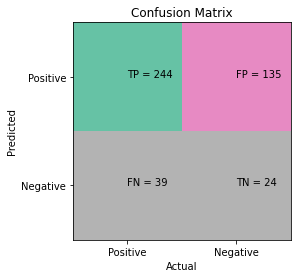

In [61]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_phrase_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

**Features extracted from 'key words' helps model in performing better. They have better positive predictions than the later one. However, using 'key-phrase' based features improves the negative predictions.**

# Sklearn Pipline

In [62]:
tweets2['sentiment'] = tweets2['sentiment'].apply(lambda x: 0 if x=='neg' else 1)

C:\Users\Rohit Shelar\AppData\Local\Temp\ipykernel_32372\1256094425.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets2['sentiment'] = tweets2['sentiment'].apply(lambda x: 0 if x=='neg' else 1)


In [63]:
pipeline_ls = make_pipeline(CountVectorizer(max_df=0.90, min_df=2, tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), LogisticRegression())

In [65]:
X_train, X_test, y_train, y_test = train_test_split(tweets2.Tweets, tweets2.sentiment)


In [66]:
pipeline_ls.fit(X_train, y_train)

C:\Users\Rohit Shelar\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.9, min_df=2, stop_words='english',
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)),
                ('logisticregression', LogisticRegression())])

In [67]:
pipeline_ls.score(X_test,y_test)

0.8722826086956522

In [68]:
pickle.dump(pipeline_ls,open('sentiment_analysis.pkl','wb'))

In [69]:
loaded_model = pickle.load(open('sentiment_analysis.pkl', 'rb'))
result = loaded_model.score(X_test,y_test)
print(result)

0.8722826086956522


In [70]:
p = ['RT @chubiei: After his divorce, Kanye West is the richest black American with an estimated net worth of $6.6billion. Elon Musk &amp; Jeff Bezos…']
result = loaded_model.predict(p)

In [71]:
print(result)

[1]


In [73]:
tweets['Tweets'][2]

'@joerogan @Spotify Great interview!'